In [83]:
import numpy as np
%load_ext autoreload
%autoreload 2
import dsp_lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

def downscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * (coeff)

In [85]:
file_path = "qpsk_rrc_float64.bin"
data_type = 'float64'

source_samples = dsp_lib.read_signal(file_path, data_type, 0, 0, '')


[[19542.13441926]
 [ 5934.51886685]
 [  103.36318612]
 [17108.38352564]
 [14781.75649987]
 [ -850.33416621]
 [ 9641.17221127]
 [20536.05202869]
 [ 4291.96349255]
 [-3757.67678129]]
[[19542.13441926]
 [ 5934.51886685]
 [  103.36318612]
 [17108.38352564]
 [14781.75649987]
 [ -850.33416621]
 [ 9641.17221127]
 [20536.05202869]
 [ 4291.96349255]
 [-3757.67678129]]


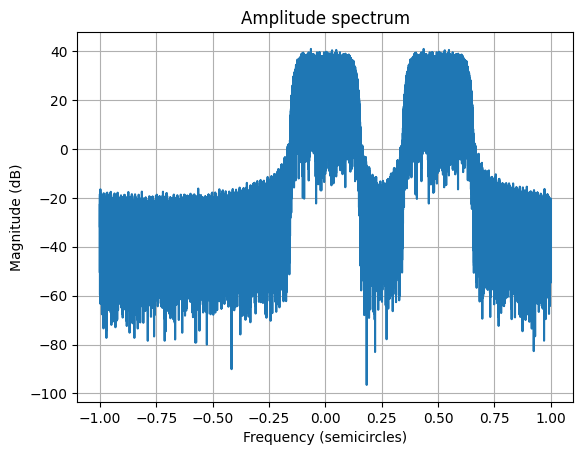

array([[-22.89212483],
       [-33.47524743],
       [-27.00233145],
       ...,
       [-38.08481654],
       [-25.52348824],
       [-30.60571195]])

In [86]:

dsp_lib.sum_double_val(8, 9)
dsp_lib.make_cmplx_sig(source_samples)

sig = dsp_lib.make_cmplx_sig(source_samples)
dsp_lib.plot_spectrum(sig, 0)

In [87]:
N = 129
Fs = 1
T_symb = 8
s_rrc = dsp_lib.gen_rrc_filter_impulse_response(N, Fs, T_symb)

[-23214.83367494+47793.91738725j -43159.86960069+55399.68423918j
 -58781.61383224+58913.0094848j  -68621.76011393+58479.00426001j
 -71991.02936731+54680.93383158j -69161.71448615+48337.74200032j
 -61165.82774235+40294.90852158j -49519.77985779+31378.05611013j
 -35939.95477359+22343.89017316j -22075.25855993+13927.02161143j]


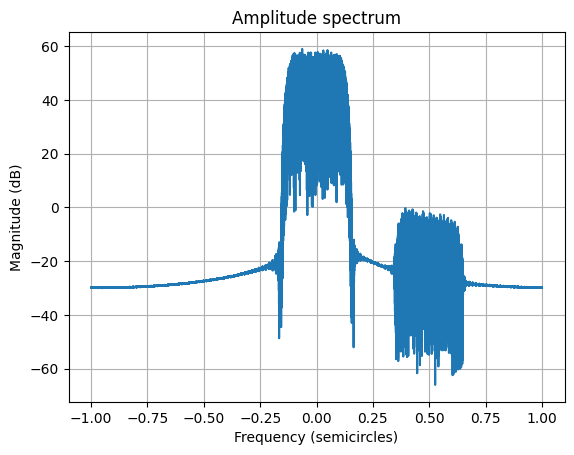

[48292.14665471-18969.21165537j 58465.25641033-12062.36433209j
 67323.24066282 -2026.45447292j 74037.69604902+10192.9515627j
 78110.76085897+23119.60309432j 79324.25849196+35222.81385823j
 77436.47535706+45022.23833725j 72276.55912283+51007.72534623j
 64009.76403979+51954.10558131j 53012.54401482+47351.60051879j]


In [88]:
sig_rrc = np.convolve(sig, s_rrc, 'same')
print(sig_rrc[len(sig_rrc) - 10:])
dsp_lib.plot_spectrum(sig_rrc, 1)
dsp_lib.save_cmplx_sig(sig_rrc, "qpsk_rrc_after_py_rrc_fl64.bin", 'float64')

[-23214.832+47793.918j -43159.867+55399.684j -58781.613+58913.008j
 -68621.766+58479.004j -71991.03 +54680.938j -69161.71 +48337.742j
 -61165.824+40294.914j -49519.777+31378.057j -35939.96 +22343.887j
 -22075.26 +13927.022j]
[48292.15 -18969.21j  58465.254-12062.365j 67323.234 -2026.456j
 74037.69 +10192.951j 78110.76 +23119.605j 79324.26 +35222.82j
 77436.47 +45022.24j  72276.57 +51007.727j 64009.758+51954.11j
 53012.543+47351.594j]


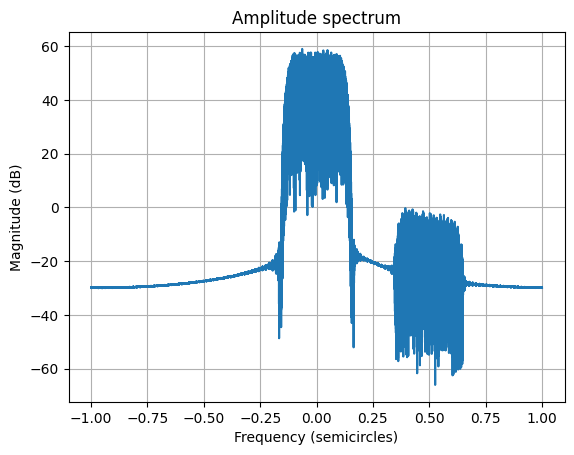

[-0.00527526 -0.00399103 -0.00164843  0.00129551]
[-0.00527526 -0.00399103 -0.00164843  0.00129551]
<class 'numpy.float64'>
9.253751671184363e-11


In [89]:
sig_fl32 = np.array(sig,  dtype=np.csingle)
s_rrc_fl32 = np.array(s_rrc, dtype = np.float32)
sig_rrc_fl32 = np.convolve(sig_fl32, s_rrc_fl32, 'same')
print(sig_rrc_fl32[len(sig_rrc_fl32) - 10:])
dsp_lib.save_cmplx_sig(sig_rrc_fl32, "qpsk_rrc_after_py_rrc_fl32.bin", data_type='float32')
dsp_lib.plot_spectrum(sig_rrc_fl32, 2)
print(s_rrc[:4])
print(s_rrc_fl32[:4])
print(type(s_rrc[0]))
print(s_rrc[0] - s_rrc_fl32[0])

In [90]:
sig_rrc_scaled = downscale_to_i16(sig_rrc)
max(sig_rrc_scaled)

(119774.99777920544-100188.57253933603j)
119774.99777920544
119693.90611283846
0.27357128455475366


(32767-27408.716487293277j)

In [91]:
max(sig_rrc)

(119774.99777920544-100188.57253933603j)

In [92]:
sig_rrc[-10:]

array([-23214.83367494+47793.91738725j, -43159.86960069+55399.68423918j,
       -58781.61383224+58913.0094848j , -68621.76011393+58479.00426001j,
       -71991.02936731+54680.93383158j, -69161.71448615+48337.74200032j,
       -61165.82774235+40294.90852158j, -49519.77985779+31378.05611013j,
       -35939.95477359+22343.89017316j, -22075.25855993+13927.02161143j])

In [93]:
len(sig_rrc_fl32)

1032000